In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch import Tensor
import torchmetrics

from torch.utils.data import TensorDataset, DataLoader

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# get the file
PETRO_FILE = Path('data/PETR3_2000_to_2024.csv')

In [5]:
df_petro = pd.read_csv(PETRO_FILE)

In [6]:
df_petro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6220 entries, 0 to 6219
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6220 non-null   object 
 1   Close   6220 non-null   float64
dtypes: float64(1), object(1)
memory usage: 97.3+ KB


In [7]:
# adjust the date type
df_petro['Date'] = pd.to_datetime(df_petro['Date'])
df_petro = df_petro.set_index('Date')

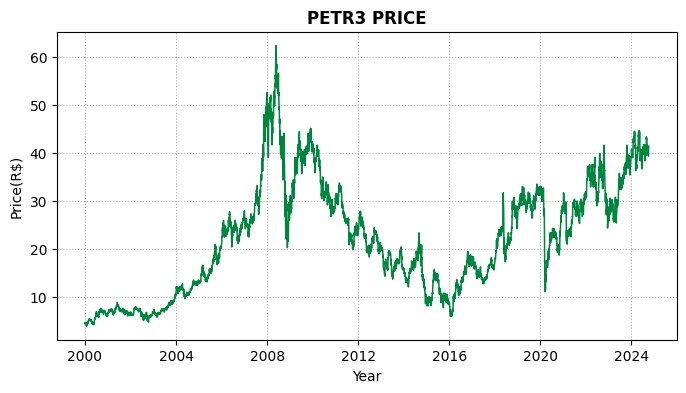

In [8]:
# plot the stocks graph
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df_petro, color='#00853F', linestyle='-', linewidth=1.1)
ax.grid(True, linestyle=':')
ax.set_title('PETR3 PRICE', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Price(R$)')
plt.show()

In [9]:
# split into train and test dataset
petr3_time_series = torch.tensor(df_petro['Close'].values)
petr3_train = petr3_time_series[:6040]
petr3_test = petr3_time_series[6040:]

In [10]:
print('LEN TIME SERIE TRAIN:', len(petr3_train))
print('LEN TIME SERIE TEST:', len(petr3_test))

LEN TIME SERIE TRAIN: 6040
LEN TIME SERIE TEST: 180


In [11]:
# L: number of days that will be "seen"
L = 15

def make_lookback(data: Tensor, lookback: int = L):
    '''
    This function breaks (reshapes) a one-dimensional tensor into a 3-dimensional tensor being:
    (number of sequences, size of the sequences, number of features in the sequences)
    '''
    data = data.unfold(0, lookback + 1, 1).unsqueeze(-1)
    X = data[:, :-1, :]
    y = data[:, -1, :]
    return X.to(torch.float32), y.to(torch.float32)

In [12]:
X_train, y_train = make_lookback(petr3_train)
X_test, y_test = make_lookback(petr3_test)

In [13]:
B = 124  # Batch Size for train

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=B)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=len(test_dataset))

In [14]:
# configs for model
H_in = 1  # input features
H_out = 4  # output features
N_layers = 4  # stack rnns
LR = 0.001  # learning rate
EPOCHS = 200  # num epochs for training

***

# Metrics

In [15]:
model_error = torchmetrics.MetricCollection({
    "RMSE": torchmetrics.MeanSquaredError(squared=False).to(device),
    "MAE": torchmetrics.MeanAbsoluteError().to(device)
})

# RNN

In [16]:
# building the model
class RNNPETR3(nn.Module):
    def __init__(
        self,
        input_size: int = H_in,
        hidden_size: int = H_out,
        output_size: int = 1, 
        num_layers: int = N_layers
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Camada totalmente conectada (linear) para predição
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.output_block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Linear(hidden_size * 2, 1)
        )
    
    def forward(self, x):
        # x has format (batch_size, seq_len, input_size), hidden state will not be propagated
        x, _ = self.rnn(x)
        # Consider only the last state of the sequence to predict the next value
        x = x[:, -1, :]
        # Passes through linear to obtain the final output
        x = self.output_block(x)
        return x

In [17]:
rnn_model = RNNPETR3().to(device)

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=LR)

In [19]:
def plot_model_learning(
    y_train: Tensor,
    y_hat_train: Tensor,
    y_test: Tensor,
    y_hat_test: Tensor
) -> None:
    '''
    This function plots two graphs: 
    - one comparing the model prediction with the real values for the training set
    - the other for the test set.
    '''
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

    # Plot for training set
    axs[0].plot(y_train, label="Y - Train", color='black', linestyle='-', linewidth=1)
    axs[0].plot(y_hat_train, label="Y_hat - Train", color='red', linestyle=':', linewidth=1)
    axs[0].set_title("True vs Pred - Train")
    axs[0].set_xlabel("Samples")
    axs[0].set_ylabel("Prices")
    axs[0].grid(True, linestyle=':', alpha=0.5)
    axs[0].legend()

    # Plot for test set
    axs[1].plot(y_test, label="Y - Test", color='black', linestyle='-', linewidth=1)
    axs[1].plot(y_hat_test, label="Y_hat - Test", color='red', linestyle=':', linewidth=1)
    axs[1].set_title("True vs Pred - Test")
    axs[1].set_xlabel("Samples")
    axs[1].set_ylabel("Prices")
    axs[1].grid(True, linestyle=':', alpha=0.5)
    axs[1].legend()

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

Epoch [50/200], Loss: 129.7470


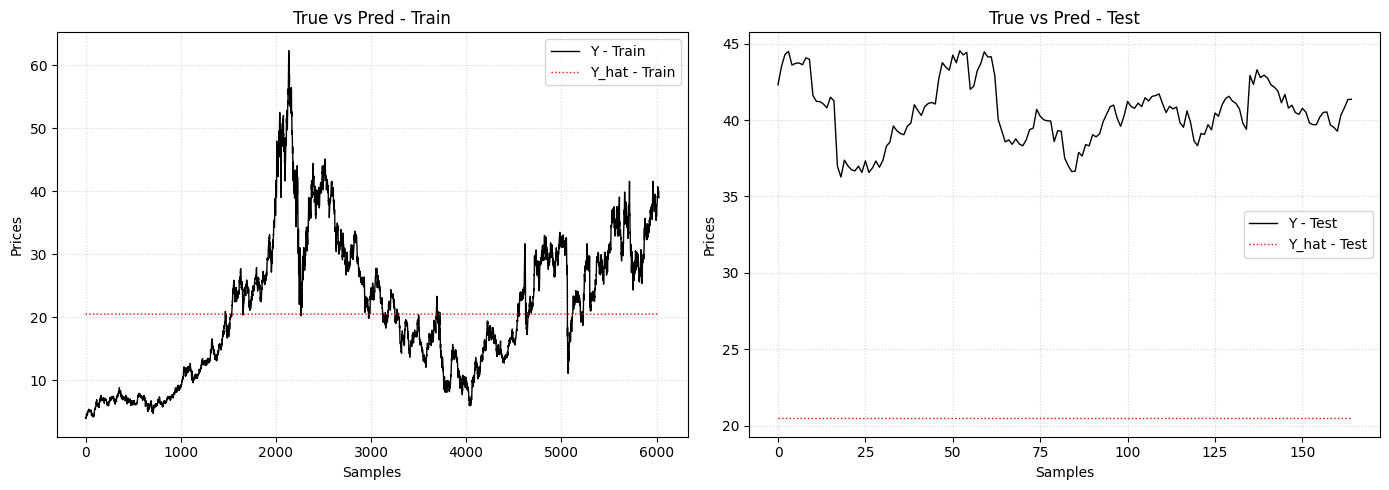

Epoch [100/200], Loss: 20.6939


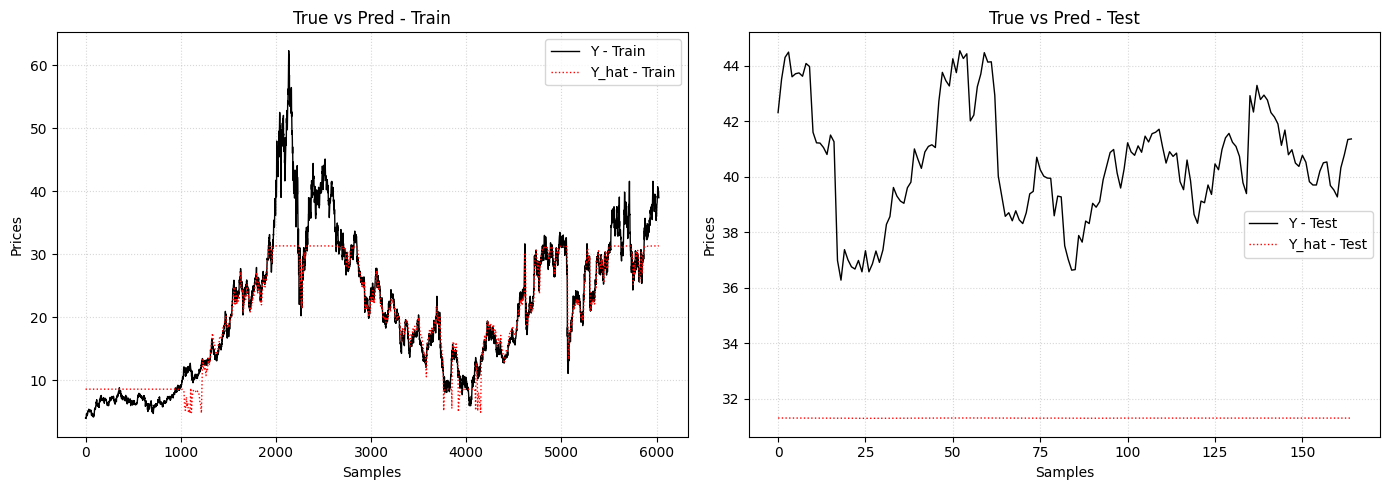

Epoch [150/200], Loss: 14.4790


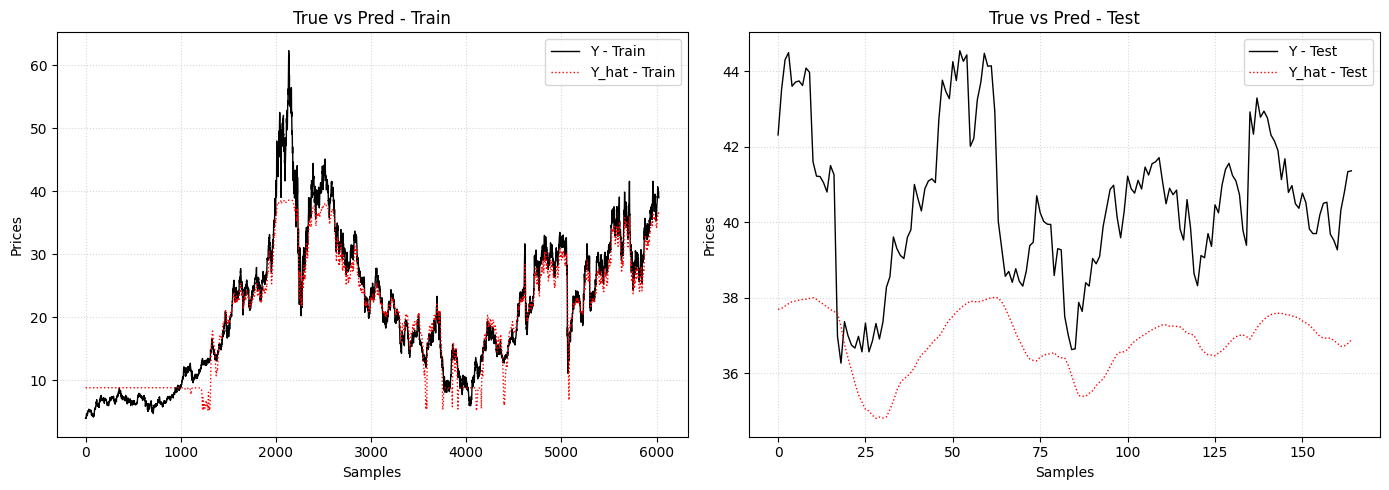

Epoch [200/200], Loss: 3.3821


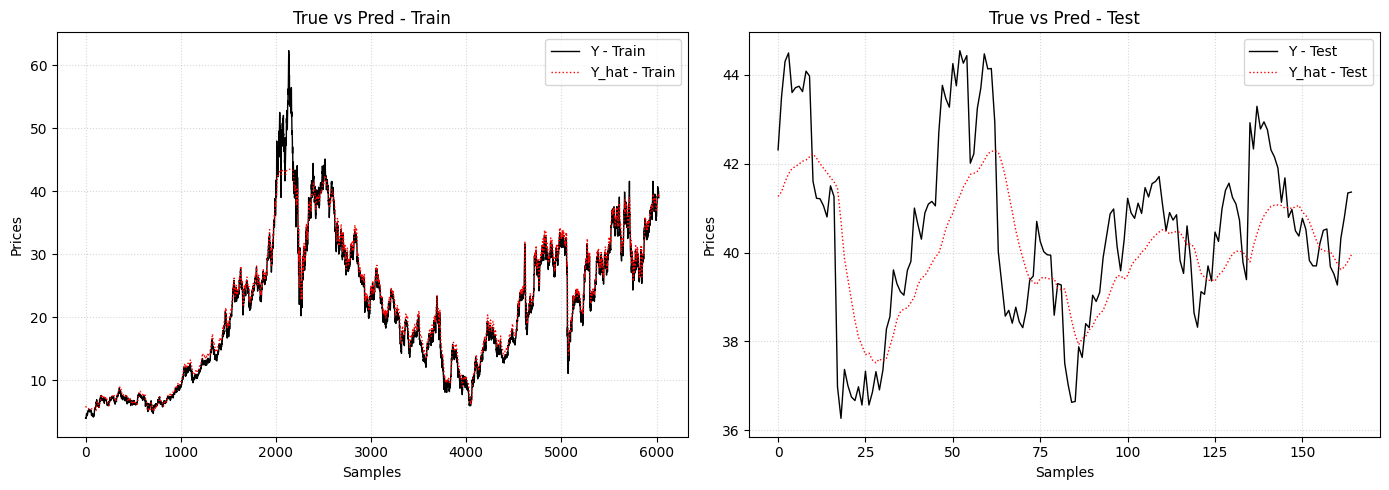

TEST ERROR: {'MAE': tensor(1.2224, device='cuda:0'), 'RMSE': tensor(1.5228, device='cuda:0')}


In [20]:
PLOT_EVERY_EPOCHS = 50
optimizer.zero_grad(set_to_none=True)
for epoch in range(EPOCHS):
    rnn_model.train()
    epoch_loss = 0.0
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = rnn_model(X)

        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    if (epoch + 1) % PLOT_EVERY_EPOCHS == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.4f}")
        rnn_model.eval()
        y_pred_train = []
        y_true_train = []

        y_pred_test = []
        y_true_test = []
        with torch.no_grad():
            for X, y in train_loader:
                X, y = X.to(device), y.to(device)
                preds = rnn_model(X)
                y_pred_train.extend(preds.view(-1).tolist())
                y_true_train.extend(y.view(-1).tolist())
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                preds = rnn_model(X)
                y_pred_test.extend(preds.view(-1).tolist())
                y_true_test.extend(y.view(-1).tolist())

        plot_model_learning(
            y_train=y_true_train,
            y_hat_train=y_pred_train,
            y_test=y_true_test,
            y_hat_test=y_pred_test
        )
        rnn_model.train()
print(f'TEST ERROR: {model_error(preds, y)}')

***

# LSTM

In [21]:
# building the model
class LSTMPETR3(nn.Module):
    def __init__(
        self,
        input_size: int = H_in,
        hidden_size: int = H_out,
        output_size: int = 1, 
        num_layers: int = N_layers
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Camada totalmente conectada (linear) para predição
        self.output_block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Linear(hidden_size * 2, 1)
        )
    
    def forward(self, x):
        # x has format (batch_size, seq_len, input_size), hidden state will not be propagated
        x, _ = self.lstm(x)
        # Consider only the last state of the sequence to predict the next value
        x = x[:, -1, :]
        # Passes through linear to obtain the final output
        x = self.output_block(x)
        return x

In [22]:
lstm_model = LSTMPETR3().to(device)

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR)

Epoch [50/200], Loss: 7.3437


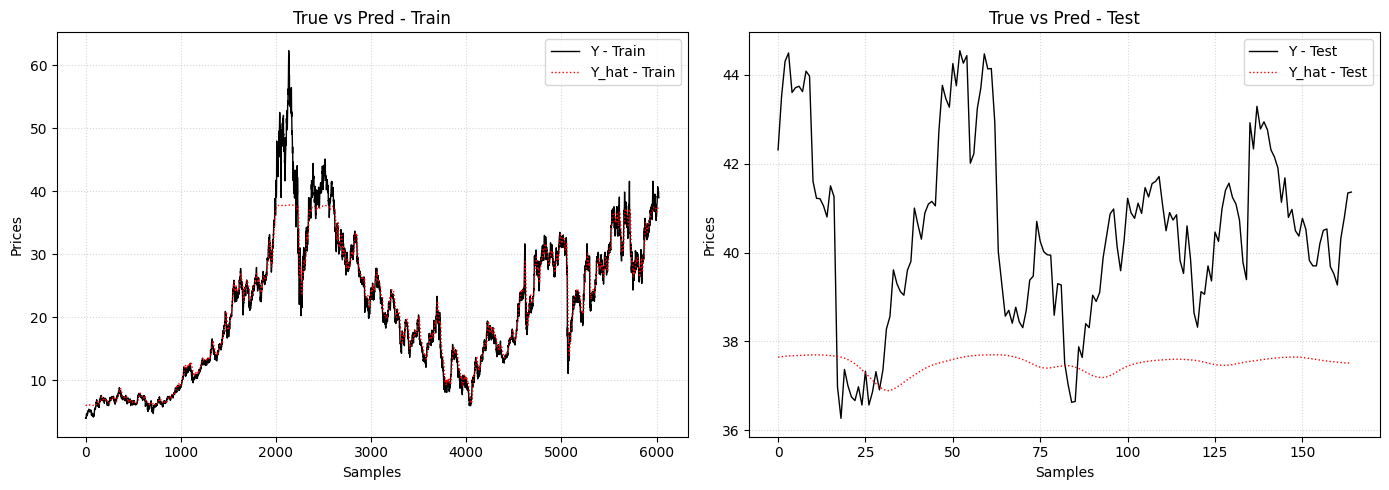

Epoch [100/200], Loss: 3.9642


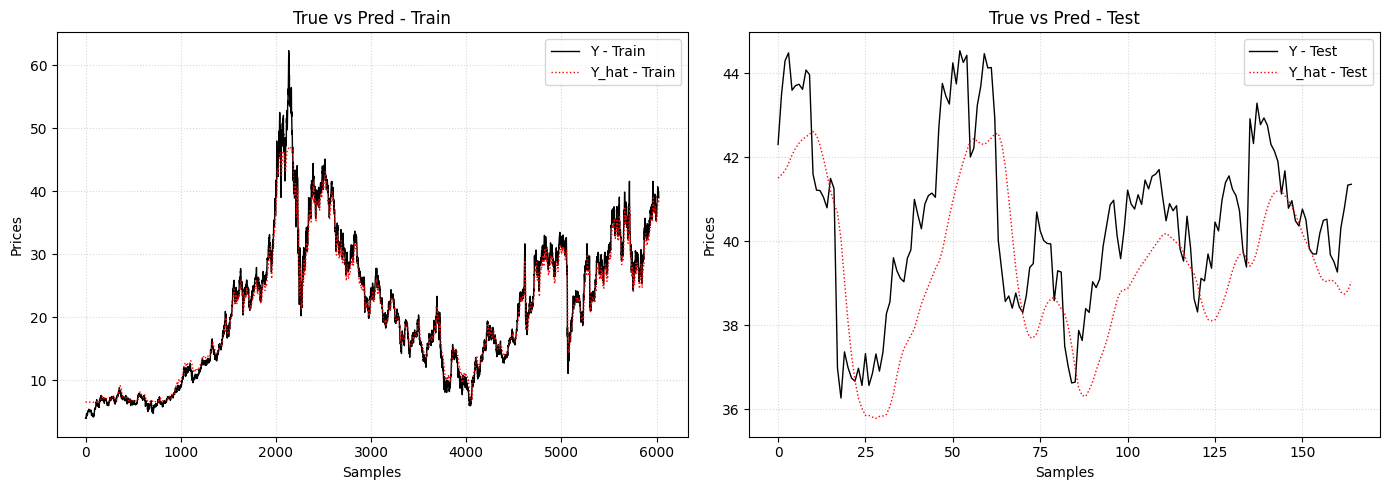

Epoch [150/200], Loss: 1.1542


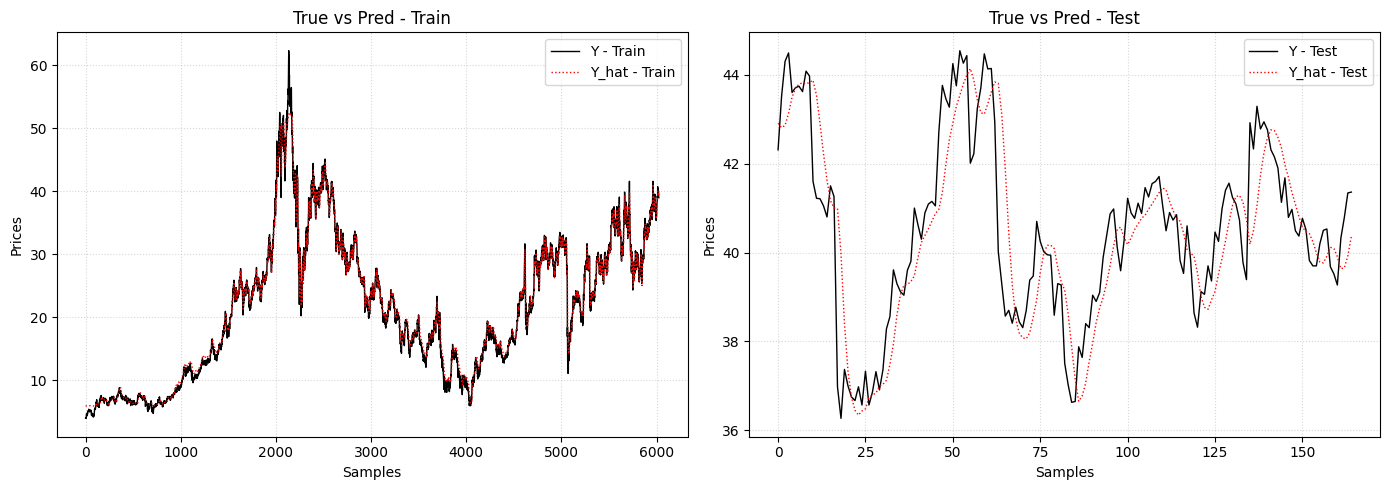

Epoch [200/200], Loss: 0.8973


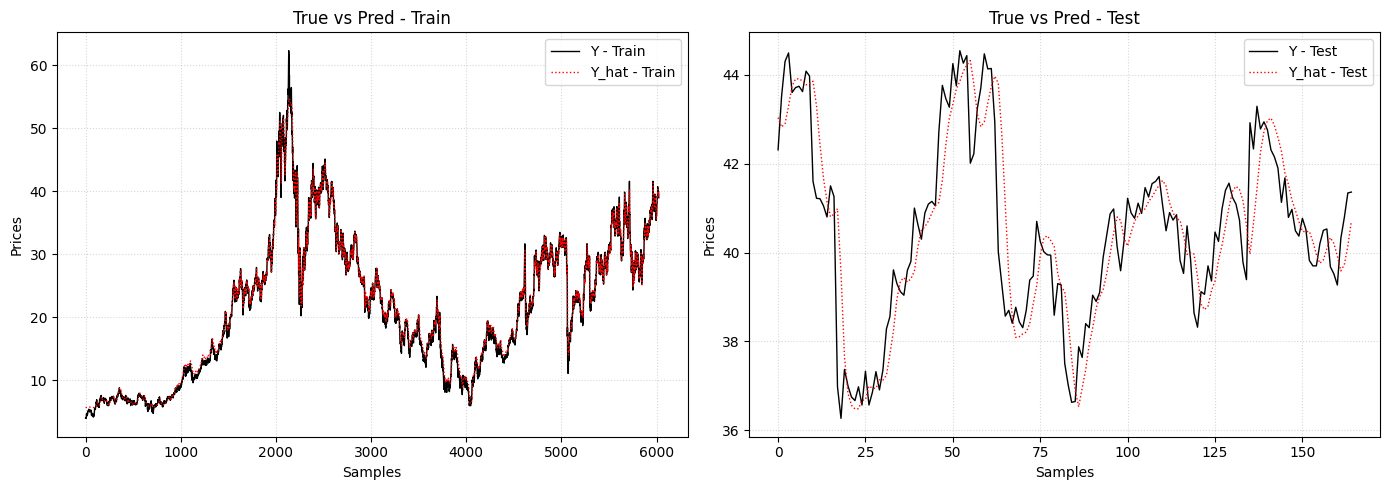

TEST ERROR: {'MAE': tensor(0.7295, device='cuda:0'), 'RMSE': tensor(1.0144, device='cuda:0')}


In [24]:
PLOT_EVERY_EPOCHS = 50
optimizer.zero_grad(set_to_none=True)
for epoch in range(EPOCHS):
    lstm_model.train()
    epoch_loss = 0.0
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = lstm_model(X)

        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    if (epoch + 1) % PLOT_EVERY_EPOCHS == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.4f}")
        lstm_model.eval()
        y_pred_train = []
        y_true_train = []

        y_pred_test = []
        y_true_test = []
        with torch.no_grad():
            for X, y in train_loader:
                X, y = X.to(device), y.to(device)
                preds = lstm_model(X)
                y_pred_train.extend(preds.view(-1).tolist())
                y_true_train.extend(y.view(-1).tolist())
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                preds = lstm_model(X)
                y_pred_test.extend(preds.view(-1).tolist())
                y_true_test.extend(y.view(-1).tolist())

        plot_model_learning(
            y_train=y_true_train,
            y_hat_train=y_pred_train,
            y_test=y_true_test,
            y_hat_test=y_pred_test
        )
        lstm_model.train()
print(f'TEST ERROR: {model_error(preds, y)}')

***

# GRU

In [25]:
class GRUPETR3(nn.Module):
    def __init__(
        self,
        input_size: int = H_in,
        hidden_size: int = H_out,
        output_size: int = 1, 
        num_layers: int = N_layers
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # Camada totalmente conectada (linear) para predição
        self.output_block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Linear(hidden_size * 2, 1)
        )
    
    def forward(self, x):
        # x has format (batch_size, seq_len, input_size), hidden state will not be propagated
        x, _ = self.gru(x)
        # Consider only the last state of the sequence to predict the next value
        x = x[:, -1, :]
        # Passes through linear to obtain the final output
        x = self.output_block(x)
        return x

In [26]:
gru_model = GRUPETR3().to(device)

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=LR)

Epoch [50/200], Loss: 129.6691


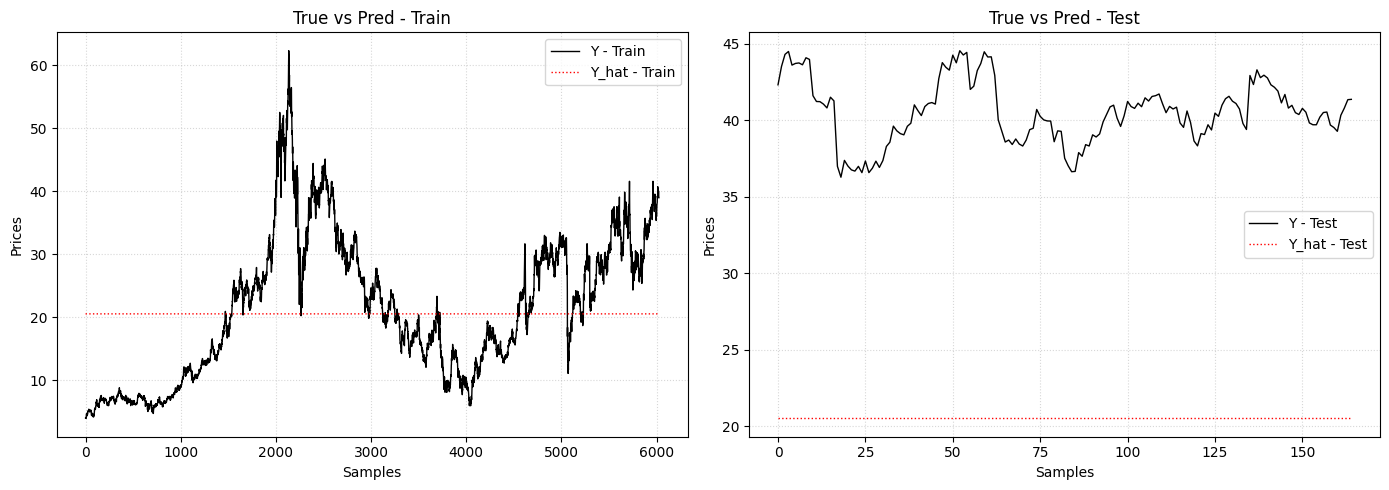

Epoch [100/200], Loss: 21.1256


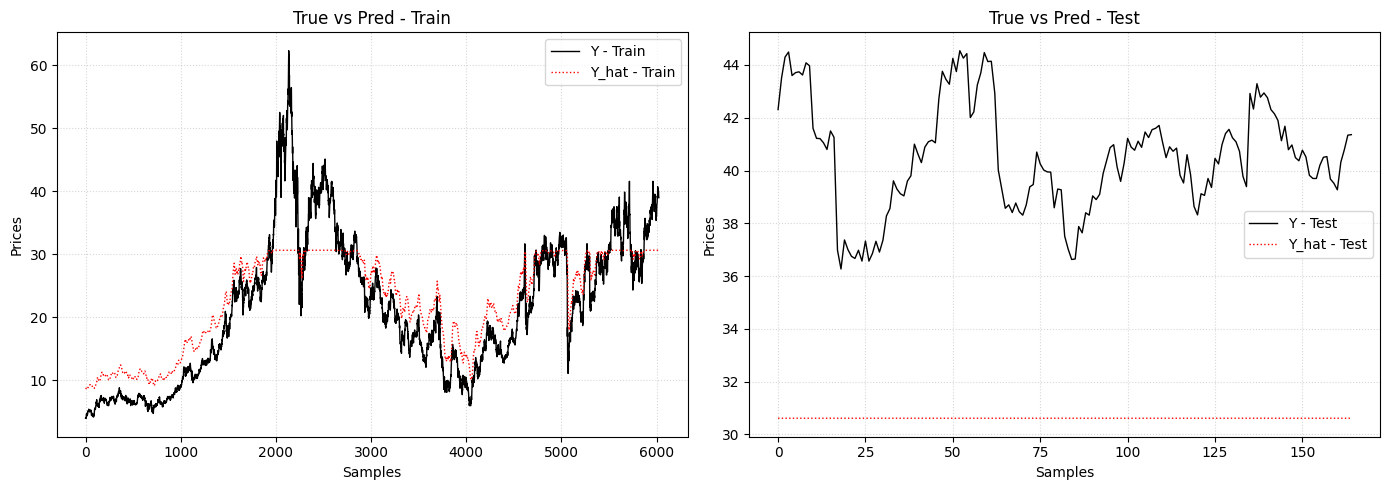

Epoch [150/200], Loss: 4.1630


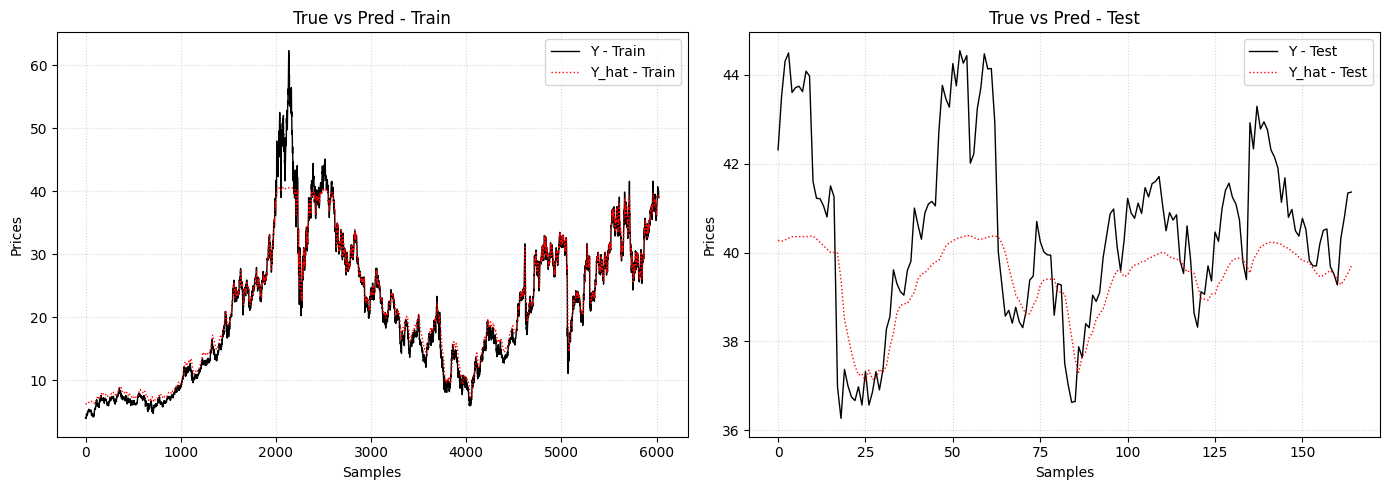

Epoch [200/200], Loss: 1.7850


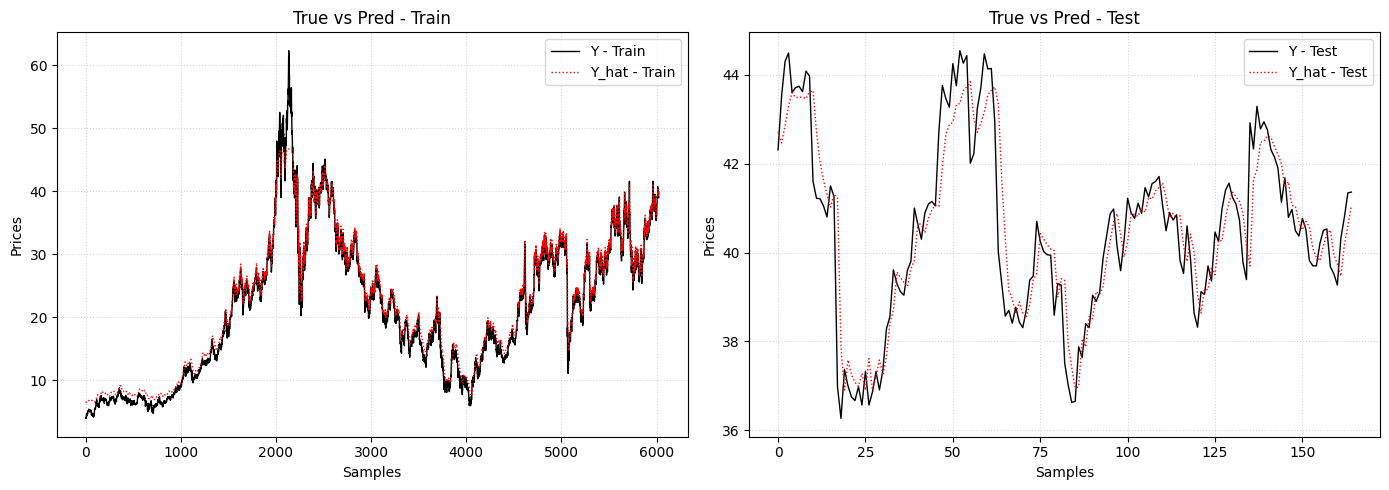

TEST ERROR: {'MAE': tensor(0.6190, device='cuda:0'), 'RMSE': tensor(0.8689, device='cuda:0')}


In [28]:
PLOT_EVERY_EPOCHS = 50
optimizer.zero_grad(set_to_none=True)
for epoch in range(EPOCHS):
    gru_model.train()
    epoch_loss = 0.0
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = gru_model(X)

        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    if (epoch + 1) % PLOT_EVERY_EPOCHS == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.4f}")
        gru_model.eval()
        y_pred_train = []
        y_true_train = []

        y_pred_test = []
        y_true_test = []
        with torch.no_grad():
            for X, y in train_loader:
                X, y = X.to(device), y.to(device)
                preds = gru_model(X)
                y_pred_train.extend(preds.view(-1).tolist())
                y_true_train.extend(y.view(-1).tolist())
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                preds = gru_model(X)
                y_pred_test.extend(preds.view(-1).tolist())
                y_true_test.extend(y.view(-1).tolist())

        plot_model_learning(
            y_train=y_true_train,
            y_hat_train=y_pred_train,
            y_test=y_true_test,
            y_hat_test=y_pred_test
        )
        gru_model.train()
print(f'TEST ERROR: {model_error(preds, y)}')

# Ensemble Method (RNN, LSTM, GRU)

In [29]:
from dataclasses import dataclass

In [30]:
@dataclass
class EnsembleModel:
    rnn: RNNPETR3 = rnn_model
    lstm: LSTMPETR3 = lstm_model
    gru: GRUPETR3 = gru_model

    def __post_init__(self):
        self.rnn.eval()
        self.lstm.eval()
        self.gru.eval()

    @torch.no_grad()
    def __call__(self, x):
        return self.predict(x)

    def predict(self, x):
        y_hat_rnn = self.rnn(x)
        y_hat_lstm = self.lstm(x)
        y_hat_gru = self.gru(x)
        
        stack_preds = torch.stack(
            (y_hat_rnn, y_hat_lstm, y_hat_gru)
        )
        y_hat = torch.mean(stack_preds, dim=0, keepdim=True)
        return y_hat

In [31]:
ensemble_model = EnsembleModel()

In [32]:
y_hat = ensemble_model(X)

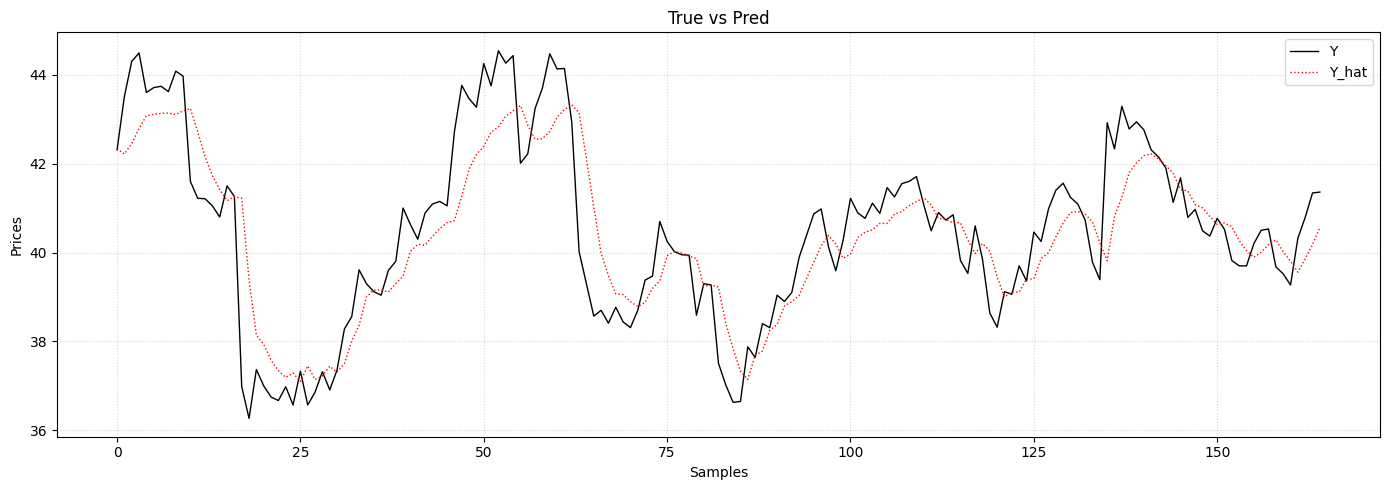

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5)) 
# Plot for training set
ax.plot(y.view(-1).tolist(), label="Y", color='black', linestyle='-', linewidth=1)
ax.plot(y_hat.view(-1).tolist(), label="Y_hat", color='red', linestyle=':', linewidth=1)
ax.set_title("True vs Pred")
ax.set_xlabel("Samples")
ax.set_ylabel("Prices")
ax.grid(True, linestyle=':', alpha=0.5)
ax.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [36]:
y.shape

torch.Size([165, 1])

In [37]:
print(f'ENSEMBLE TEST ERROR: {model_error(y_hat, y.unsqueeze(0))}')

ENSEMBLE TEST ERROR: {'MAE': tensor(0.7726, device='cuda:0'), 'RMSE': tensor(1.0304, device='cuda:0')}
